In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import random
import torch 
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, train_test_split
from transformers import RobertaModel, RobertaConfig, RobertaTokenizer
from transformers import AlbertModel, AlbertConfig, AlbertTokenizer
from transformers import BertModel, BertConfig, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from torch.utils.data import Dataset,DataLoader, TensorDataset
from torch.autograd import Variable
from torch.utils.data.sampler import SequentialSampler, RandomSampler, WeightedRandomSampler
import numpy as np
from tqdm.auto import tqdm, trange
import time
import matplotlib.pyplot as plt
import copy

warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)


In [3]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_reports = pd.read_pickle("reports_processed.pkl")
df_reports.sample(10)

,publishedDate,targetPriceChange,bullets,recommendationId,total_text,prepped_total_text
18007,2014-02-04 08:23:00+00:00,False,[{'text': 'Kesko reported Q4 clean EBIT of EUR...,2,Q4 EBIT a bit better than we and consensus exp...,fourth quarter earnings before interest and ta...
3798,2012-02-08 06:50:00+00:00,False,[{'text': 'We expect Storebrand to report a ne...,1,Target price cut due to proposal to limit the ...,target price cut due to proposal to limit the ...
4484,2012-07-09 15:39:00+00:00,False,[{'text': 'We expect Lassila & Tikanoja to rep...,1,We estimate a Q2 EBIT of EUR 9.9m. We expect L...,we estimate a second quarter earnings before i...
2518,2011-05-11 07:05:00+00:00,False,[{'text': 'Hexagon’s underlying EBIT was 5% ab...,1,Underlying EBIT 5% better than expected; upgra...,underlying earnings before interest and taxes ...
18370,2014-07-09 14:52:00+00:00,False,[{'text': 'We have included the acquisition of...,2,Higher target price due to acquisition and low...,higher target price due to acquisition and low...
2884,2011-07-29 06:40:00+00:00,False,[{'text': 'We have cut our EPS forecast by 7% ...,1,"Estimates, target slightly down – opinion unch...",estimates target slightly down – opinion unch...
20221,2017-04-28 06:24:00+00:00,False,[{'text': 'The Q1 2017 results added little va...,2,Quarterly results are non-events – Q1 2017 was...,quarterly results are non events – first quart...
2214,2011-04-12 07:07:00+00:00,False,[{'text': 'After a 23% y-o-y increase in passe...,1,Slightly better Q2 than we expected. After a 2...,slightly better second quarter than we expecte...
13260,2019-09-05 05:51:00+00:00,False,"[{'text': '', 'header': 'CEO Lotta Lyrå has co...",1,CEO Lotta Lyrå has confirmed a step-up in reta...,chief executive officer lotta lyrå has confirm...
11436,2018-11-05 13:08:00+00:00,False,"[{'text': '', 'header': 'Eli Lilly has just th...",1,Eli Lilly has just that Trulicity significantl...,eli <company> has just that trulicity signific...


### Remove data with 0 label.

In [4]:
df_reports = df_reports[df_reports["recommendationId"] >= 1]
df_reports["recommendationId"] = df_reports["recommendationId"] - 1
df_reports.head()

,publishedDate,targetPriceChange,bullets,recommendationId,total_text,prepped_total_text
376,2010-03-01 06:23:00+00:00,False,[{'text': 'Golar LNG reported a Q4 2009 EBITDA...,0,Q4: Early Winter lifts EBIT. Golar LNG reporte...,fourth quarter early winter lifts earnings be...
377,2010-03-01 06:23:00+00:00,False,"[{'text': 'CTC Media, in which MTG owns 39%, r...",0,Significantly outpaced the Russian TV ad marke...,significantly outpaced the russian tv ad marke...
378,2010-03-01 09:25:00+00:00,False,[{'text': 'We expect BoConcept to slightly upg...,0,We believe an earnings upgrade is on the cards...,we believe an earnings upgrade is on the cards...
379,2010-03-01 10:26:00+00:00,False,[{'text': 'Questerre reported very good horizo...,0,First middle-Utica horizontal well exceeds all...,first middle utica horizontal well exceeds <cu...
380,2010-03-01 11:01:00+00:00,False,[{'text': 'Thrane & Thrane reported sales of D...,0,Guidance narrowed down as expected. Thrane & T...,guidance narrowed down as expected <company> ...


### Remove data with null text or too short text

In [5]:
df_empty = df_reports[df_reports['prepped_total_text'].map(len) < 100]
df_reports =df_reports.drop(df_reports[df_reports["prepped_total_text"].map(len) < 100].index )

In [6]:
# Get the lists of sentences and their labels.
sentences = df_reports.prepped_total_text.values
labels = df_reports.recommendationId.values

In [7]:
# tokenizer = RobertaTokenizer.from_pretrained('/home/jupyter/pretrained-models/roberta-large/')
tokenizer = BertTokenizer.from_pretrained('/home/jupyter/pretrained-models/fin-bert/')

### Example outputs from the tokenizer.

In [8]:
# Print the original sentence.
print('Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  fourth quarter  early winter lifts earnings before interest and taxes  <company> reported a fourth quarter <year> earnings before interest  taxes  depreciation  and amortization of <currency> <number> million  against our <currency> <number> million forecast and the <currency> <number> million consensus  inquiry   the pre tax deviations were similar  the better than expected results were caused by higher earnings for the spot trading of vessels in its daughter company  <company> energy  management indicates that utilisation in the spot market will be low for the first half of <year> and as a consequence we have cut our <year> earnings per share forecast by <percent>  however  dividend payments will start earlier  in second quarter <year> instead of third quarter <year>  risks and directions  <company> charters largely take care of its cash flow  which we believe are attractively priced in the market  we also consider the changes in the daughter company <company> energy  whic

In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
MAX_LENGTH = 500
# For every sentence...
for sent in tqdm(sentences):
    encoded_sent = tokenizer.encode_plus(
                sent,            
                add_special_tokens=True, 
                max_length=MAX_LENGTH, 
                pad_to_max_length=True
    )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent['input_ids'])
    attention_masks.append(encoded_sent['attention_mask'])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Att Masks:', attention_masks[0])


Original:  fourth quarter  early winter lifts earnings before interest and taxes  <company> reported a fourth quarter <year> earnings before interest  taxes  depreciation  and amortization of <currency> <number> million  against our <currency> <number> million forecast and the <currency> <number> million consensus  inquiry   the pre tax deviations were similar  the better than expected results were caused by higher earnings for the spot trading of vessels in its daughter company  <company> energy  management indicates that utilisation in the spot market will be low for the first half of <year> and as a consequence we have cut our <year> earnings per share forecast by <percent>  however  dividend payments will start earlier  in second quarter <year> instead of third quarter <year>  risks and directions  <company> charters largely take care of its cash flow  which we believe are attractively priced in the market  we also consider the changes in the daughter company <company> energy  whi

In [ ]:
 print('Max sentence length: ', max([len(sen) for sen in input_ids]))

In [10]:
# We will call the train_test_split() function from sklearn
from sklearn.model_selection import train_test_split


train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=46, test_size=0.2)
# Performing same steps on the attention masks
train_masks, test_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=46, test_size=0.2)

train_labels_temp = copy.deepcopy(train_labels)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=46, test_size=0.125)
# Performing same steps on the attention masks
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_labels_temp,
                                             random_state=46, test_size=0.125)

del train_labels_temp

In [11]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)


train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

### Class balancing vs No class balancing

In [16]:
#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
print(train_inputs.size())
print(train_masks.size())
print(train_labels.size())
weights = 1. / torch.tensor([84,53,14], dtype=torch.float)

samples_weights = weights[train_data.tensors[2]]

# print(samples_weights.size())
# print(samples_weights)
# temp_numpy = samples_weights.numpy()
# print(np.unique(temp_numpy, return_counts=True))

# train_sampler = WeightedRandomSampler(
#     weights=samples_weights,
#     num_samples=int(len(train_data) * 1.5),
#     replacement=True)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation and test set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

torch.Size([17667, 500])
torch.Size([17667, 500])
torch.Size([17667])


In [23]:
#Loading the pre-trained BERT model from huggingface library

from transformers import RobertaForSequenceClassification, AlbertForSequenceClassification
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# model = RobertaForSequenceClassification.from_pretrained(
#     "/home/jupyter/pretrained-models/roberta-large/", 
#     num_labels = 3,   
#     output_attentions = False, 
#     output_hidden_states = False, )


model = BertForSequenceClassification.from_pretrained(
    "/home/jupyter/pretrained-models/fin-bert/", 
    num_labels = 3,   
    output_attentions = False, 
    output_hidden_states = False, )

# model.load_state_dict(torch.load("/home/jupyter/saved-models/roberta-large-500-finetuned.pth"))
# uncomment this if need to load our models
# Teeling the model to run on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name,param.size())

### Freeze the bottom layers
### Need to change unfreeze_layers with different backbones(names might be different)

In [25]:
# unfreeze the top layers and heads
# unfreeze_layers = ['layer.8','layer.9','layer.10','layer.11','roberta.pooler','classifier.'] # roberta-base
# unfreeze_layers = ['layer.16','layer.17','layer.18','layer.19','layer.20','layer.21','layer.22','layer.23','roberta.pooler','classifier.'] # roberta-large
unfreeze_layers = ['layer.8','layer.9','layer.10','layer.11','bert.pooler','classifier.'] # fin-bert

for name ,param in model.named_parameters():
    param.requires_grad = False
    for ele in unfreeze_layers:
        if ele in name:
            param.requires_grad = True
            break
            
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param.size())

bert.encoder.layer.8.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.8.attention.self.query.bias torch.Size([768])
bert.encoder.layer.8.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.8.attention.self.key.bias torch.Size([768])
bert.encoder.layer.8.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.8.attention.self.value.bias torch.Size([768])
bert.encoder.layer.8.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.8.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.8.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.8.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder.layer.8.intermediate.dense.weight torch.Size([3072, 768])
bert.encoder.layer.8.intermediate.dense.bias torch.Size([3072])
bert.encoder.layer.8.output.dense.weight torch.Size([768, 3072])
bert.encoder.layer.8.output.dense.bias torch.Size([768])
bert.encoder.layer.8.output.LayerNorm.weight torch.

In [26]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8 
                )


In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 15

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### Training and Validating

In [30]:
import random

predictions_list = []

device = torch.device("cuda")

# Store the average loss after each epoch so we can plot them.
loss_values = []

best_acc = 0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in tqdm(enumerate(train_dataloader),bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}"):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        loss = outputs[0]
        
        total_loss += loss.item()

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    preds = None
    labels = None

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        targets_np = b_labels.detach().cpu().numpy()
        
        if preds is None:
            preds = logits
        else:
            preds = np.append(preds,logits, axis=0)

        if labels is None:
            labels = targets_np
        else:
            labels = np.append(labels, targets_np)
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    if eval_accuracy/nb_eval_steps > best_acc:
        torch.save(model.state_dict(), "/home/jupyter/saved-models/fin-bert-500-finetuned.pth")
        best_acc = eval_accuracy/nb_eval_steps
        print("  Model saved.")
    preds = np.argmax(preds, axis=1)
    predictions_list.append(preds)



======== Epoch 1 / 15 ========
Training...



  Average training loss: 0.71833
  Training epoch took: 0:08:40
Running Validation...



  Accuracy: 0.81250
  Validation took: 0:00:43
  Model saved.

======== Epoch 2 / 15 ========
Training...



  Average training loss: 0.40358
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.82265
  Validation took: 0:00:43
  Model saved.

======== Epoch 3 / 15 ========
Training...



  Average training loss: 0.37211
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.82476
  Validation took: 0:00:43
  Model saved.

======== Epoch 4 / 15 ========
Training...



  Average training loss: 0.34273
  Training epoch took: 0:08:38
Running Validation...



  Accuracy: 0.82911
  Validation took: 0:00:43
  Model saved.

======== Epoch 5 / 15 ========
Training...



  Average training loss: 0.31883
  Training epoch took: 0:08:38
Running Validation...



  Accuracy: 0.83452
  Validation took: 0:00:43
  Model saved.

======== Epoch 6 / 15 ========
Training...



  Average training loss: 0.29550
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.83188
  Validation took: 0:00:43

======== Epoch 7 / 15 ========
Training...



  Average training loss: 0.27257
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.83716
  Validation took: 0:00:43
  Model saved.

======== Epoch 8 / 15 ========
Training...



  Average training loss: 0.25210
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.84045
  Validation took: 0:00:43
  Model saved.

======== Epoch 9 / 15 ========
Training...



  Average training loss: 0.23481
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.83716
  Validation took: 0:00:43

======== Epoch 10 / 15 ========
Training...



  Average training loss: 0.21562
  Training epoch took: 0:08:38
Running Validation...



  Accuracy: 0.82397
  Validation took: 0:00:43

======== Epoch 11 / 15 ========
Training...



  Average training loss: 0.20018
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.84520
  Validation took: 0:00:43
  Model saved.

======== Epoch 12 / 15 ========
Training...



  Average training loss: 0.18299
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.84639
  Validation took: 0:00:43
  Model saved.

======== Epoch 13 / 15 ========
Training...



  Average training loss: 0.17489
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.84309
  Validation took: 0:00:43

======== Epoch 14 / 15 ========
Training...



  Average training loss: 0.16706
  Training epoch took: 0:08:38
Running Validation...



  Accuracy: 0.84151
  Validation took: 0:00:43

======== Epoch 15 / 15 ========
Training...



  Average training loss: 0.16022
  Training epoch took: 0:08:39
Running Validation...



  Accuracy: 0.84309
  Validation took: 0:00:43


[1 0 1 ... 0 0 0]


(array([1362.,    0.,    0.,    0.,    0.,  987.,    0.,    0.,    0.,
         175.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

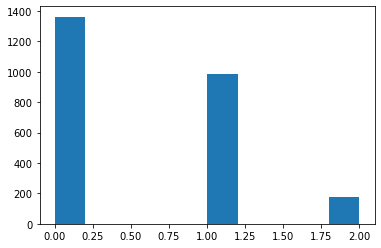

In [31]:
print(predictions_list[-1])
plt.hist(predictions_list[-1])

## Evaluation on test set (Real performance)

In [32]:
device = torch.device("cuda")
model.load_state_dict(torch.load("/home/jupyter/saved-models/fin-bert-500-finetuned.pth"))

model.eval()
t0 = time.time()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
preds = None
labels = None

# Evaluate data for one epoch
for batch in tqdm(test_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    targets_np = b_labels.detach().cpu().numpy()

    if preds is None:
        preds = logits
    else:
        preds = np.append(preds,logits, axis=0)

    if labels is None:
        labels = targets_np
    else:
        labels = np.append(labels, targets_np)

    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
print("  Testing took: {:}".format(format_time(time.time() - t0)))
# if eval_accuracy/nb_eval_steps > best_acc:
#     torch.save(model.state_dict(), "/home/jupyter/saved-models/roberta-base-500-finetuned.pth")
#     best_acc = eval_accuracy/nb_eval_steps
#     print("  Model saved.")
# preds = np.argmax(preds, axis=1)
# predictions_list.append(preds)


  Accuracy: 0.84335
  Testing took: 0:01:25


### Best results on DEV set

#### Results with origional preproseccing:

roberta-base :76.7(4layer)

roberta-large: 77.5(5layer)

roberta-large: 78.9(8layer)

fin-bert: 76.4(4layer)

#### Results with random replaced tokens:

roberta-base :76.6(4layer)

roberta-large: 79.1(8layer)

fin-bert: 76.3(6layer)

fin-bert: 75.3(4layer)

#### Results with origional preproseccing (MAX LENGTH = 350):

roberta-base:81.6(4layer)

roberta-large: 82.7(8layer)

fin-bert:81.6(4layer)

#### Results with origional preproseccing (MAX LENGTH = 500):

roberta-base: 85.7(4layer)

roberta-large: 85.9(8layer)

### Best results on TEST set
fin-bert:84.3(4layer)

roberta-base: 84.6(4layer)

roberta-large: 86.1(8layer)


### Class balancing didnt make the result better.